In [166]:
import cmath
import numpy as np
from tqdm import tqdm
import torch as t
import matplotlib.pyplot as plt
from library.plots import plot_surface
import pandas as pd

# use style from seaborn
plt.style.use('seaborn')
plt.rcParams['figure.dpi'] = 200

/var/folders/h9/1sb3bgkx6hb79gbgw7tgt0080000gn/T/ipykernel_47615/3817401536.py:10: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



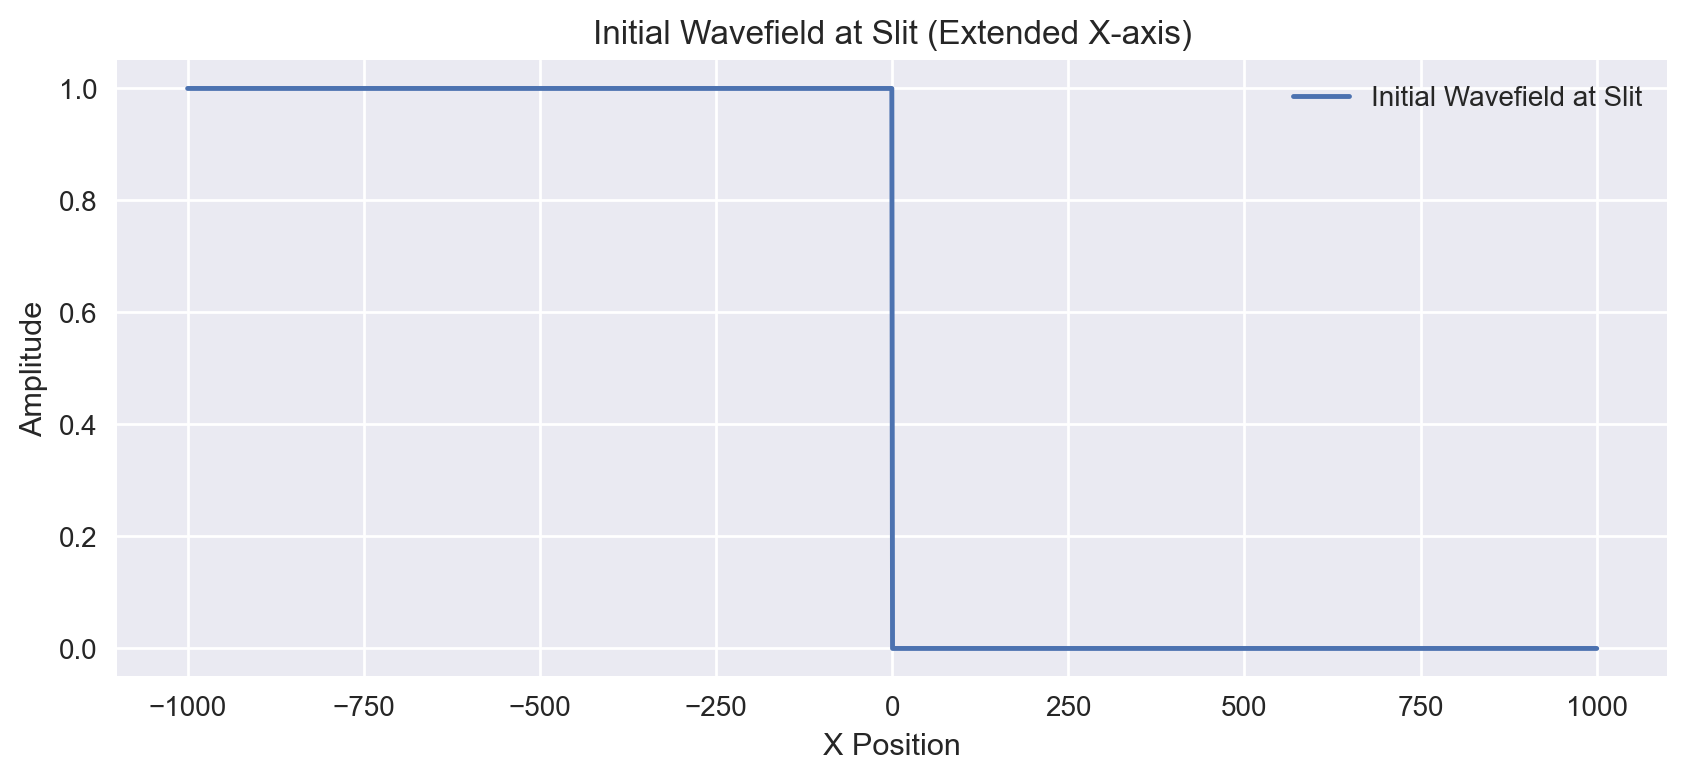

In [355]:
# Define parameters to mimic the setup of the Newtonian gravity experiment but with a 10x smaller slit
slit_width = 0  # From -10 to 10
wavelength = 0.06238
y_steps = np.linspace(1, 1000, 100)  # Screens at y=1 to y=1000

x_values_extended = np.linspace(-1000, 1000, 2000)

# Update the initial wavefield with the new x-axis range
initial_wavefield_extended = np.ones_like(x_values_extended)
# initial_wavefield_extended[np.abs(x_values_extended) > slit_width / 2] = 0
initial_wavefield_extended[x_values_extended > slit_width / 2] = 0

# Plot the updated initial wavefield at the slit
plt.figure(figsize=(10, 4))
plt.plot(x_values_extended, initial_wavefield_extended, label='Initial Wavefield at Slit')
plt.xlabel('X Position')
plt.ylabel('Amplitude')
plt.title('Initial Wavefield at Slit (Extended X-axis)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Function to implement the Rayleigh-Sommerfeld propagation algorithm
def rayleigh_sommerfeld_propagation(initial_wavefield, x_values, y, wavelength):
    dx = x_values[1] - x_values[0]  # step size in x
    propagated_wavefield = np.zeros_like(initial_wavefield, dtype=complex)

    for i, x in tqdm(enumerate(x_values)):
        integral = 0
        for j, x_prime in enumerate(x_values):
            r = np.sqrt((x - x_prime) ** 2 + y**2)
            phase = cmath.exp(1j * 2 * np.pi / wavelength * r)
            integral += initial_wavefield[j] * phase / r * dx
        propagated_wavefield[i] = integral * y / (1j * wavelength)

    return np.abs(propagated_wavefield) ** 2  # return intensity


# Initialize an array to store the wavefield at each screen (y position)
wavefield_3D = []

# Calculate the wavefield at each y step
for y in tqdm(y_steps):
    propagated_wavefield = rayleigh_sommerfeld_propagation(
        initial_wavefield_extended, x_values_extended, y, wavelength
    )
    wavefield_3D.append(propagated_wavefield)

# Convert to a NumPy array for easier manipulation
wavefield_3D = np.array(wavefield_3D)

2000it [00:05, 358.96it/s]


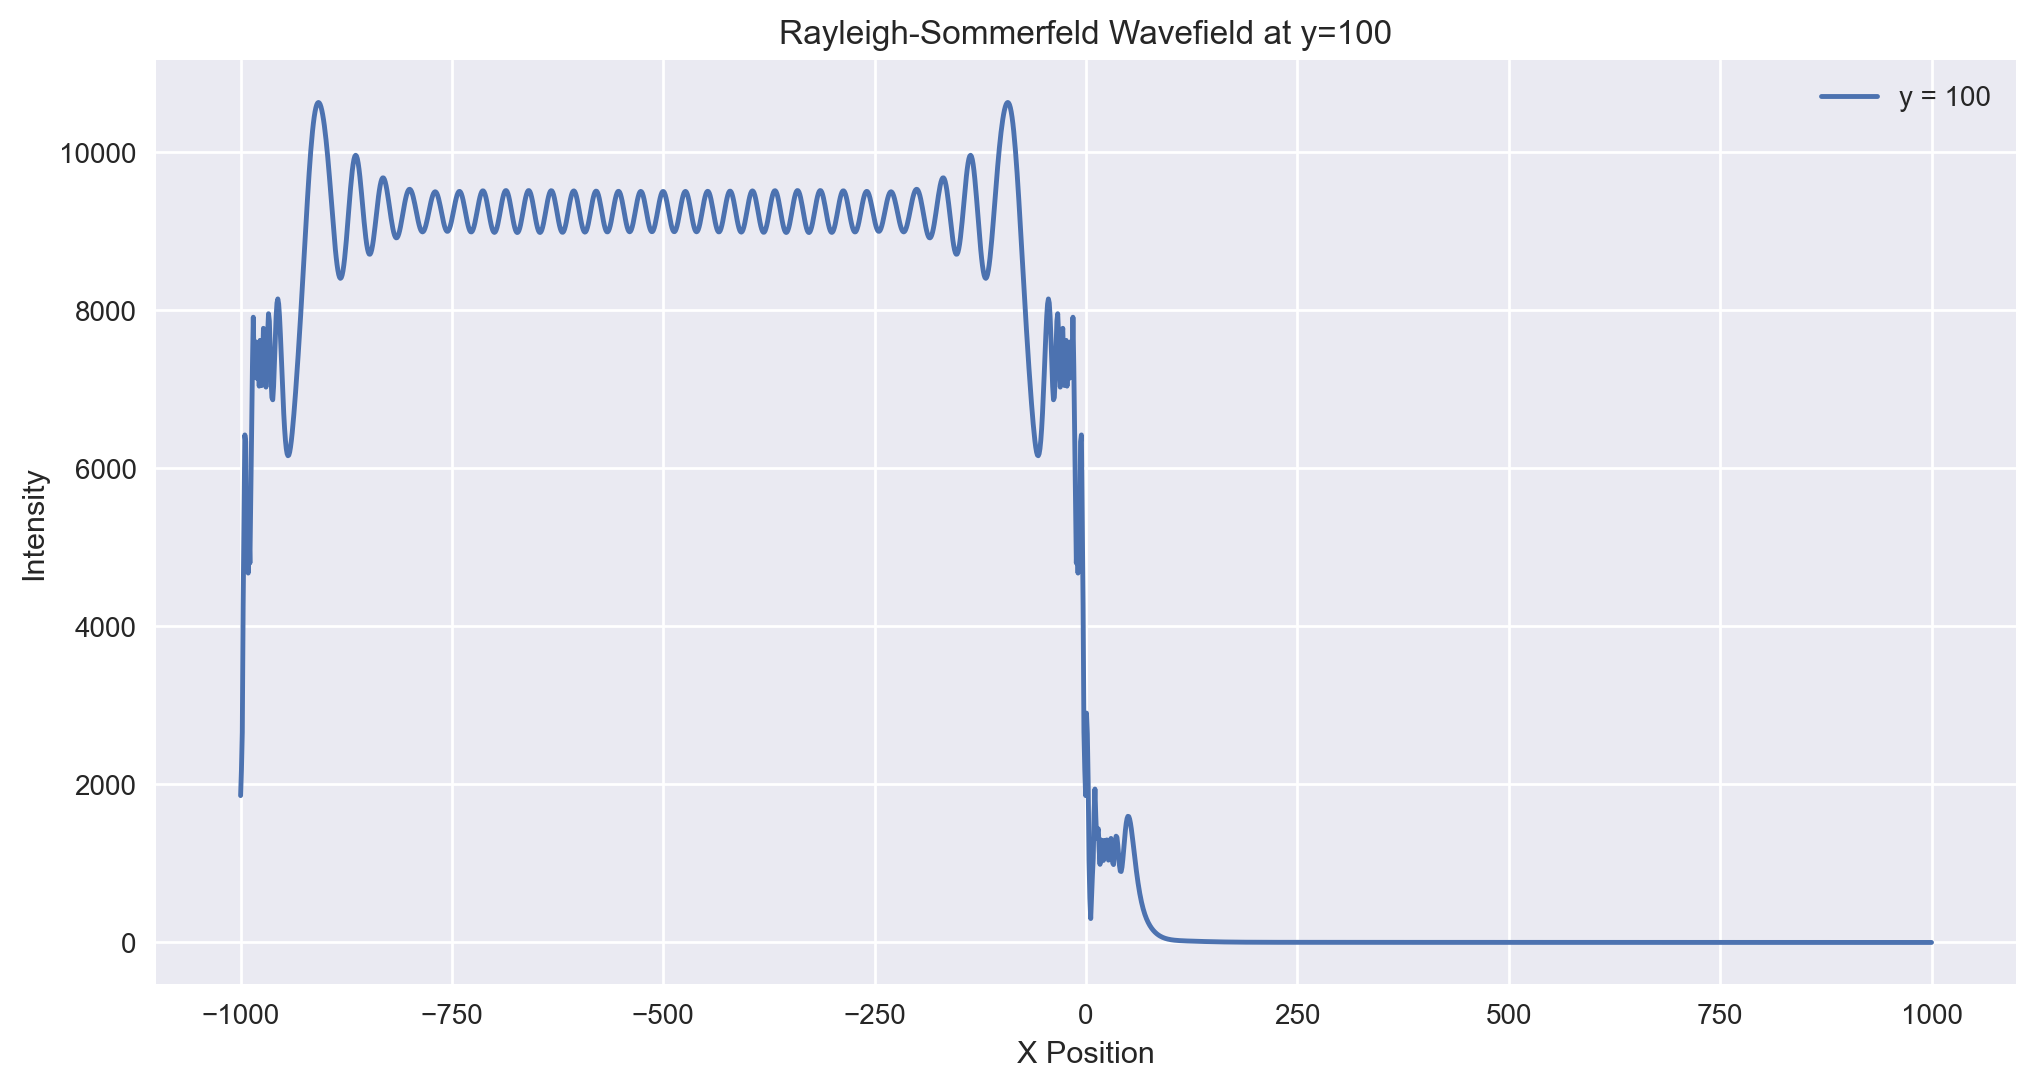

In [357]:
# Calculate the wavefield at y=100 using the Rayleigh-Sommerfeld model
wavefield_y100_RS = rayleigh_sommerfeld_propagation(initial_wavefield_extended, x_values_extended, 5, wavelength)

# Plot the wavefield at y=100 using the Rayleigh-Sommerfeld model
plt.figure(figsize=(12, 6))
plt.plot(x_values_extended, wavefield_y100_RS, label=f'y = 100')
plt.xlabel('X Position')
plt.ylabel('Intensity')
plt.title('Rayleigh-Sommerfeld Wavefield at y=100')
plt.legend()
plt.show()


100%|██████████| 101/101 [00:35<00:00,  2.88it/s]


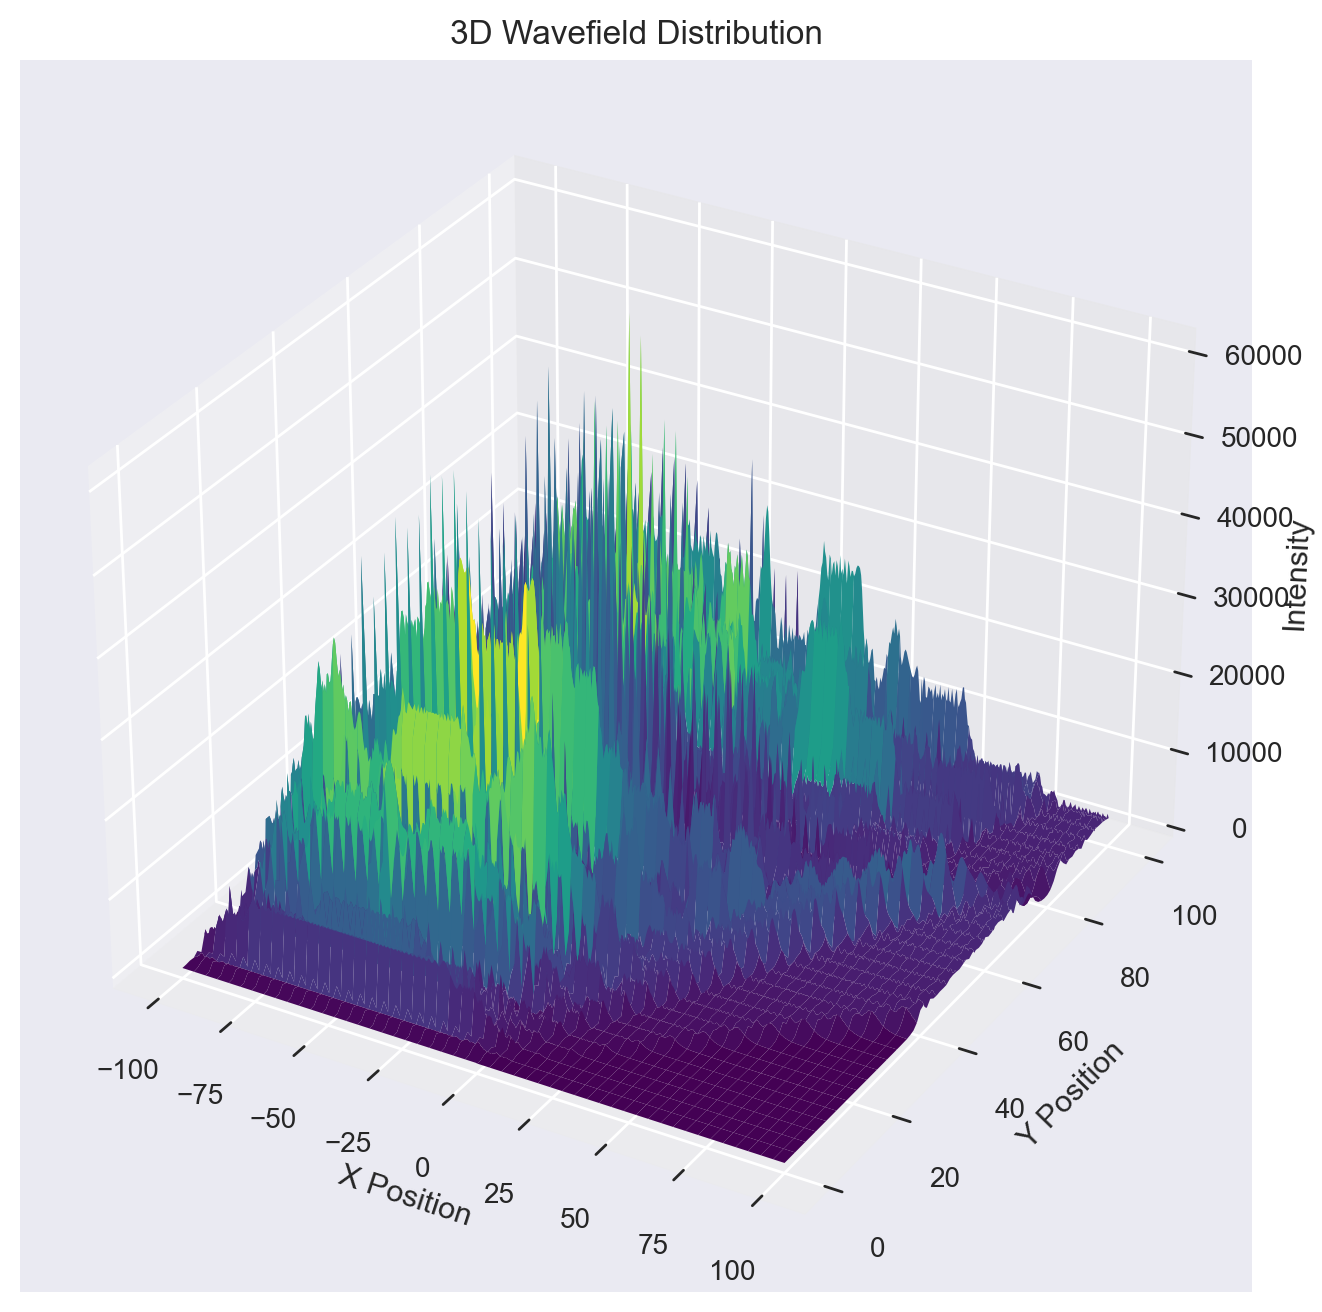

In [342]:
# Define a new range of y-values from 10 to 1000, in steps of 50
y_steps_long = np.arange(0.001, 101, 1)

# Initialize an array to store the wavefield at each screen (y position) for the longer range
wavefield_3D_long = []

# Calculate the wavefield at each y step in the longer range using the Rayleigh-Sommerfeld model
for y in tqdm(y_steps_long):
    propagated_wavefield = rayleigh_sommerfeld_propagation(initial_wavefield_extended, x_values_extended, y, wavelength)
    wavefield_3D_long.append(propagated_wavefield)

# Convert to a NumPy array for easier manipulation
wavefield_3D_long = np.array(wavefield_3D_long)

# Create a 3D plot for the calculated wavefield
from mpl_toolkits.mplot3d import Axes3D

X, Y = np.meshgrid(x_values_extended, y_steps_long)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, wavefield_3D_long, cmap='viridis')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Intensity')
ax.set_title('3D Wavefield Distribution')
plt.show()


# 2

In [1282]:
def calculate_distorted_gravitational_forces(distance_magnitudes, unit_vectors, G, alpha, k, og_grav=1, particle_masses=None):
    """
    Calculate the net distorted gravitational forces.
    
    Parameters:
        distance_magnitudes: ndarray
            The magnitudes of the distance vectors between points and nodes.
        unit_vectors: ndarray
            The unit vectors pointing from points to nodes.
        G: float
            The gravitational constant.
        alpha: float
            The amplitude of the wave-like distortion.
        k: float
            The wave number.
        og_grav: float, optional
            The original gravity multiplier (default is 1).
        particle_masses: ndarray, optional
            The masses of the particles (default is None).
            
    Returns:
        net_forces: ndarray
            The net distorted gravitational forces at each point.
    """
    if particle_masses is not None:
        force_mags = G * particle_masses[:, np.newaxis] / distance_magnitudes ** 2
    else:
        force_mags = G / distance_magnitudes ** 2

    force_mags *= (og_grav + alpha * np.cos(k * distance_magnitudes)**1)
    net_forces = np.sum(force_mags[:, :, np.newaxis] * unit_vectors, axis=1)
    return net_forces


In [1287]:
# Initialize constants
# G = 6.67430e-2  # Gravitational constant (m^3/kg/s^2)
G = 1  # Gravitational constant (m^3/kg/s^2)
alpha = 1.0  # Amplitude of wave-like distortion
lambda_ = 0.00001  # Wavelength (m)
og_grav = 1
k = 2 * np.pi / lambda_  # Wave number
time_step = 0.00001  # Time step for numerical integration (s)
total_time = 0.05  # Total simulation time (s)
num_steps = int(total_time / time_step)  # Number of time steps
epsilon = 0.0001  # Softening parameter for gravitational force (m)

# Update constants and initial conditions based on new requirements
x_scaler = 0.01
x_range = 1.0 * x_scaler
barrier_start_x1 = 0.38 * x_scaler
barrier_end_x1 = 0.45 * x_scaler
barrier_start_x2 = 0.55 * x_scaler
barrier_end_x2 = 0.62 * x_scaler
initial_velocity_magnitude = 3
particle_mass = 0.0001


# Re-initialize particle positions and masses
# Initialize particle positions and masses
num_particles = 2_000

# Update particle positions based on new requirements
particle_start_x1 = barrier_start_x1 + epsilon
particle_end_x1 = barrier_end_x1 - epsilon
particle_start_x2 = barrier_start_x2 + epsilon
particle_end_x2 = barrier_end_x2 - epsilon

# Divide the number of particles equally between the two regions
num_particles1 = num_particles // 2
num_particles2 = num_particles // 2

# Initialize particle positions for the two regions
particle_positions1 = np.linspace(
    particle_start_x1, particle_end_x1, num_particles1
).reshape(-1, 1)
particle_positions2 = np.linspace(
    particle_start_x2, particle_end_x2, num_particles2
).reshape(-1, 1)

# Combine the positions and add the y-component (which is zero)
particle_positions1 = np.hstack([particle_positions1, np.zeros((num_particles1, 1))])
particle_positions2 = np.hstack([particle_positions2, np.zeros((num_particles2, 1))])
particle_positions = np.vstack([particle_positions1, particle_positions2])

# Initialize masses for the particles
particle_masses = np.ones(num_particles) * particle_mass

particle_positions[:5], particle_positions[
    -5:
]  # Show some of the initial and final particle positions


# Re-initialize barrier
barrier_y = 0
barrier_nodes_x = np.array(
    [barrier_start_x1, barrier_end_x1, barrier_start_x2, barrier_end_x2]
)

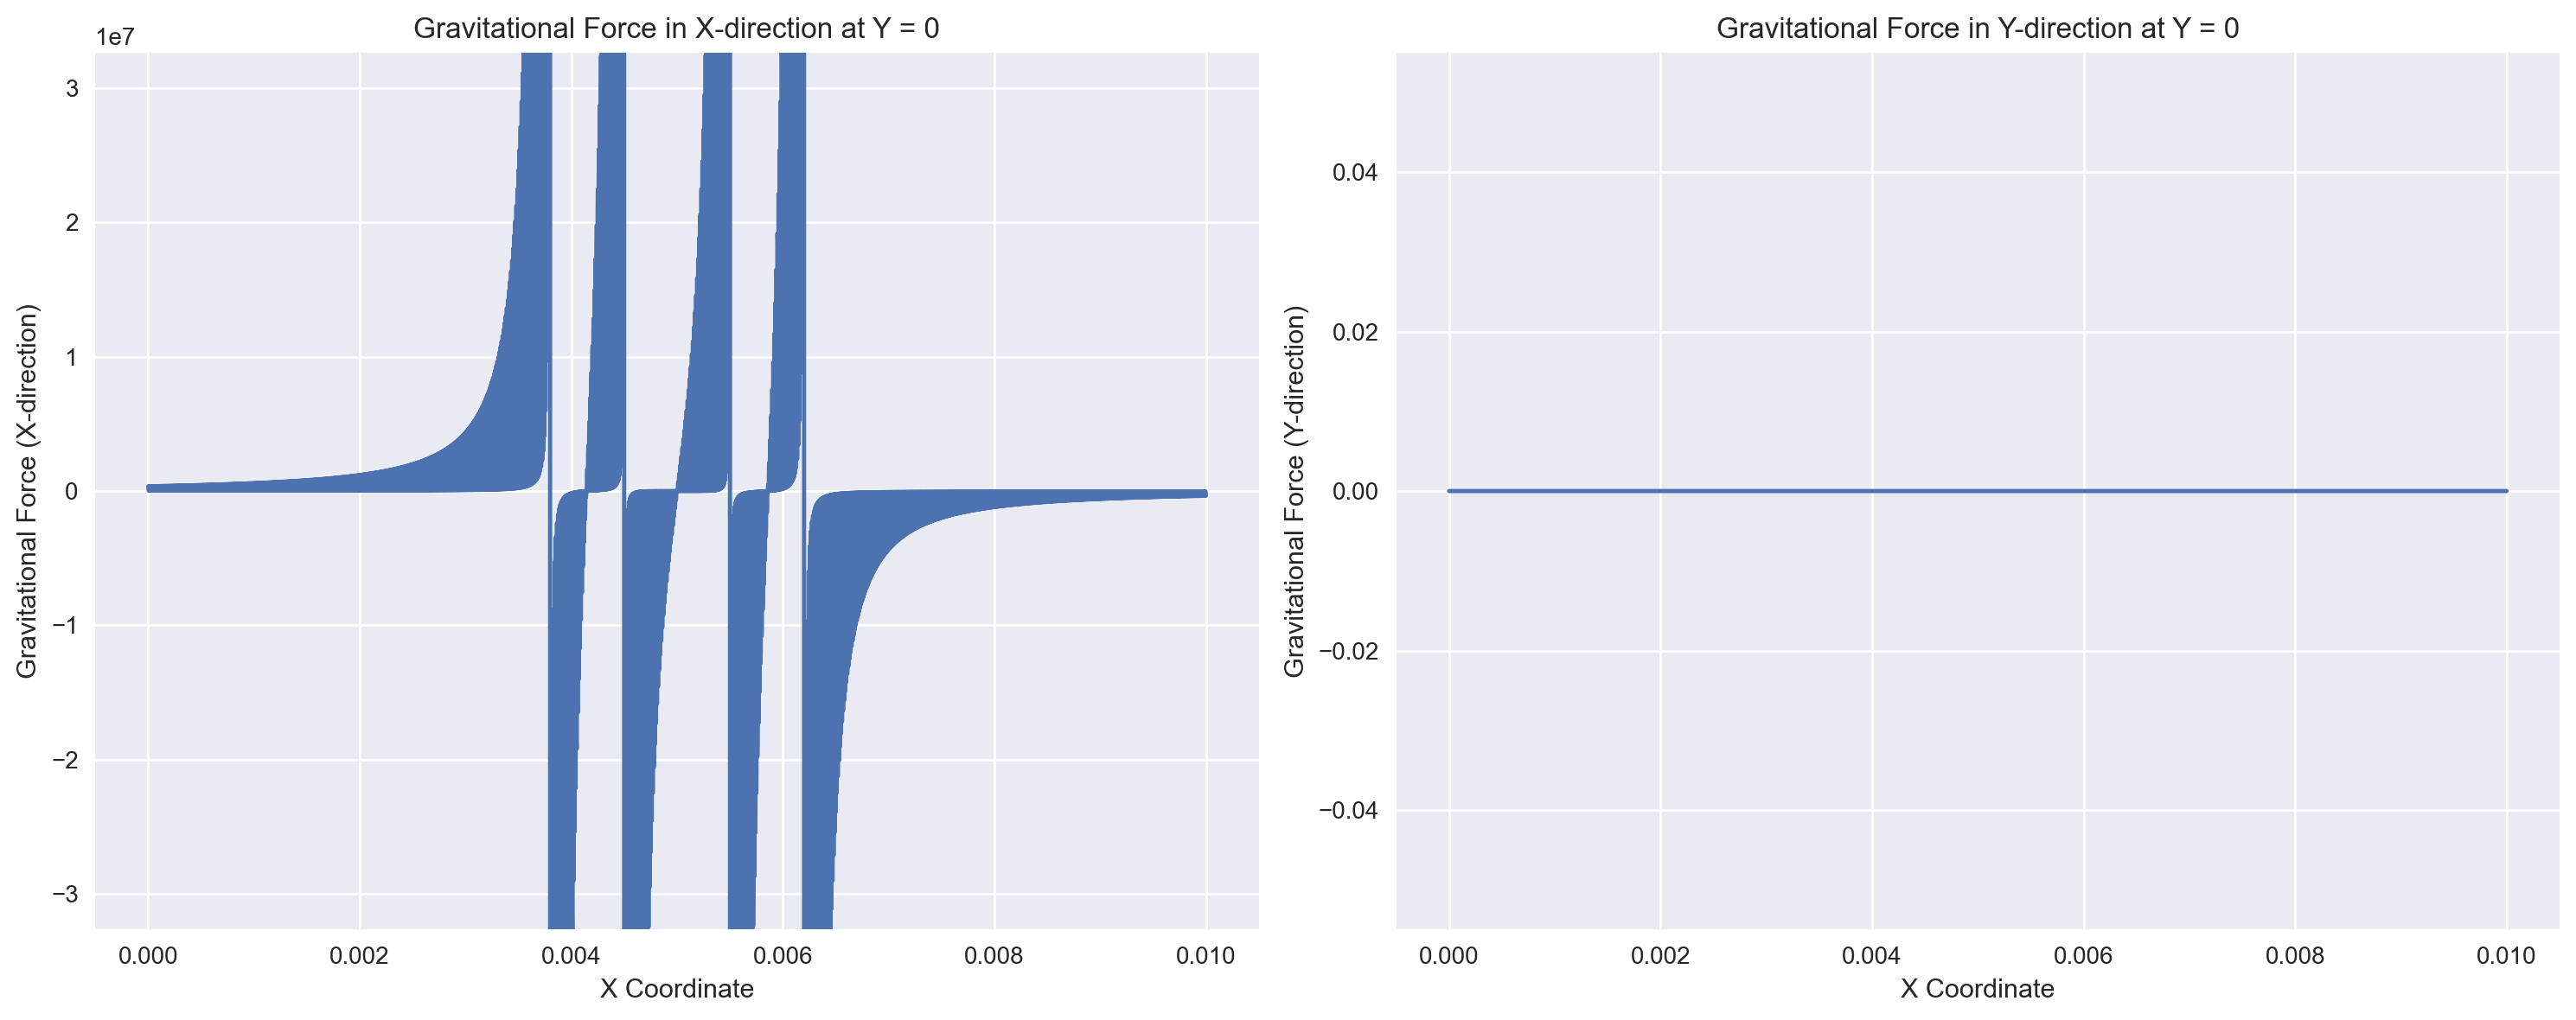

In [1288]:
# Initialize the x-coordinates for which we want to calculate the gravitational force
x_coordinates_to_evaluate = np.linspace(0, x_range, 5000)
y_coordinate = 0  # y-coordinate is set to 0

# Initialize an array to store the gravitational forces at each x-coordinate
gravitational_forces = np.zeros((len(x_coordinates_to_evaluate), 2))

# Expand dimensions for broadcasting
x_coordinates_expanded = np.expand_dims(
    np.array(
        [x_coordinates_to_evaluate, [y_coordinate] * len(x_coordinates_to_evaluate)]
    ).T,
    axis=1,
)
barrier_nodes_expanded = np.expand_dims(
    np.array([barrier_nodes_x, [barrier_y] * len(barrier_nodes_x)]).T, axis=0
)

# Calculate distance vectors and their magnitudes
distance_vectors = barrier_nodes_expanded - x_coordinates_expanded
distance_magnitudes = np.linalg.norm(distance_vectors, axis=2)

# Calculate unit vectors
unit_vectors = distance_vectors / np.expand_dims(distance_magnitudes, axis=2)

gravitational_forces = calculate_distorted_gravitational_forces(
    distance_magnitudes, unit_vectors, G, alpha, k, og_grav
)


# Plot the gravitational force in both x and y directions
plt.figure(figsize=(15, 6))

# Gravitational force in the x-direction
plt.subplot(1, 2, 1)
plt.plot(x_coordinates_to_evaluate, gravitational_forces[:, 0])
plt.xlabel("X Coordinate")
plt.ylabel("Gravitational Force (X-direction)")
plt.title(f"Gravitational Force in X-direction at Y = {y_coordinate}")
# limit y to y average
plt.ylim(-gravitational_forces[:, 0].max() / 100000, gravitational_forces[:, 0].max() / 100000)
plt.grid(True)

# Gravitational force in the y-direction
plt.subplot(1, 2, 2)
plt.plot(x_coordinates_to_evaluate, gravitational_forces[:, 1])
plt.xlabel("X Coordinate")
plt.ylabel("Gravitational Force (Y-direction)")
plt.title(f"Gravitational Force in Y-direction at Y = {y_coordinate}")
plt.grid(True)

plt.tight_layout()
plt.show()

In [1289]:
# Re-initialize velocity (all particles now have initial velocity directed towards the barrier)
particle_velocities = np.zeros((num_particles, 2))
particle_velocities[
    :, 1
] = -initial_velocity_magnitude  # Negative sign indicates motion towards the barrier
initial_velocities = particle_velocities.copy()

# Re-run the simulation loop
particle_positions_history = [particle_positions.copy()]  # Reset history

for step in tqdm(range(num_steps)):
    net_forces = np.zeros((num_particles, 2))
    
    # Calculate distances from all particles to all nodes at once
    particle_positions_expanded = np.expand_dims(particle_positions, axis=1)
    barrier_nodes_expanded = np.expand_dims(np.array([barrier_nodes_x, [barrier_y]*len(barrier_nodes_x)]).T, axis=0)
    
    distance_vectors = barrier_nodes_expanded - particle_positions_expanded
    distance_magnitudes = np.linalg.norm(distance_vectors, axis=2)
    
    # Calculate unit vectors
    unit_vectors = distance_vectors / np.expand_dims(distance_magnitudes, axis=2)
    
    net_forces = calculate_distorted_gravitational_forces(distance_magnitudes, unit_vectors, G, alpha, k, og_grav, particle_masses)

    
    # Update particle velocities and positions
    particle_velocities += net_forces * time_step
    max_velocity_magnitude = np.linalg.norm(initial_velocities, axis=1)
    current_velocity_magnitude = np.linalg.norm(particle_velocities, axis=1)
    scaling_factor = np.where(
        current_velocity_magnitude > max_velocity_magnitude,
        max_velocity_magnitude / current_velocity_magnitude,
        1,
    )
    particle_velocities *= scaling_factor[:, np.newaxis]
    particle_positions += particle_velocities * time_step
    
    # Store the updated positions for visualization
    particle_positions_history.append(particle_positions.copy())


# Convert the history to a numpy array for easier indexing
particle_positions_history = np.array(particle_positions_history)

min_y = particle_positions_history[:, :, 1].min()
# Visualize the paths of particles
# plt.figure(figsize=(15, 10))
# for i in tqdm(range(num_particles)):
#     plt.plot(
#         particle_positions_history[:, i, 0],
#         particle_positions_history[:, i, 1],
#         color="blue",
#         alpha=0.1,
#     )
# plt.scatter(
#     barrier_nodes_x,
#     np.full_like(barrier_nodes_x, barrier_y),
#     c="red",
#     marker="x",
#     label="Barrier Nodes",
# )
# # limit x range to 0 to 2
# plt.xlim(0, 2)
# # plt.ylim(-10000, 2)
# plt.xlabel("X Position")
# plt.ylabel("Y Position")
# plt.legend()
# # plt.title("Paths of Particles Under Distorted Gravitational Force")
# plt.grid(True)
# plt.show()

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:01<00:00, 2548.60it/s]


In [1290]:
import plotly.graph_objects as go
import numpy as np

# particle_positions_history = particle_positions_history[2000:, :, :]
min_y = particle_positions_history[:, :, 1].min()

# Define the bins for x and y coordinates
x_bins = np.linspace(0, x_range, 100)
y_bins = np.linspace(min_y, 0, num_steps-1)
flattened_x_positions = particle_positions_history[:, :, 0].flatten()
flattened_y_positions = particle_positions_history[:, :, 1].flatten()
H, x_edges, y_edges = np.histogram2d(
    flattened_x_positions, flattened_y_positions, bins=[x_bins, y_bins], density=True
)

# transpose T and inverse in y
H = H.T
H = H[::-1]

# Create meshgrid for x and y_steps
x_mesh, y_mesh = np.meshgrid((x_bins[:-1] + x_bins[1:]) / 2, num_steps)
plot_surface(pd.DataFrame(H), x_mesh, y_mesh, "plotly_dark", {})

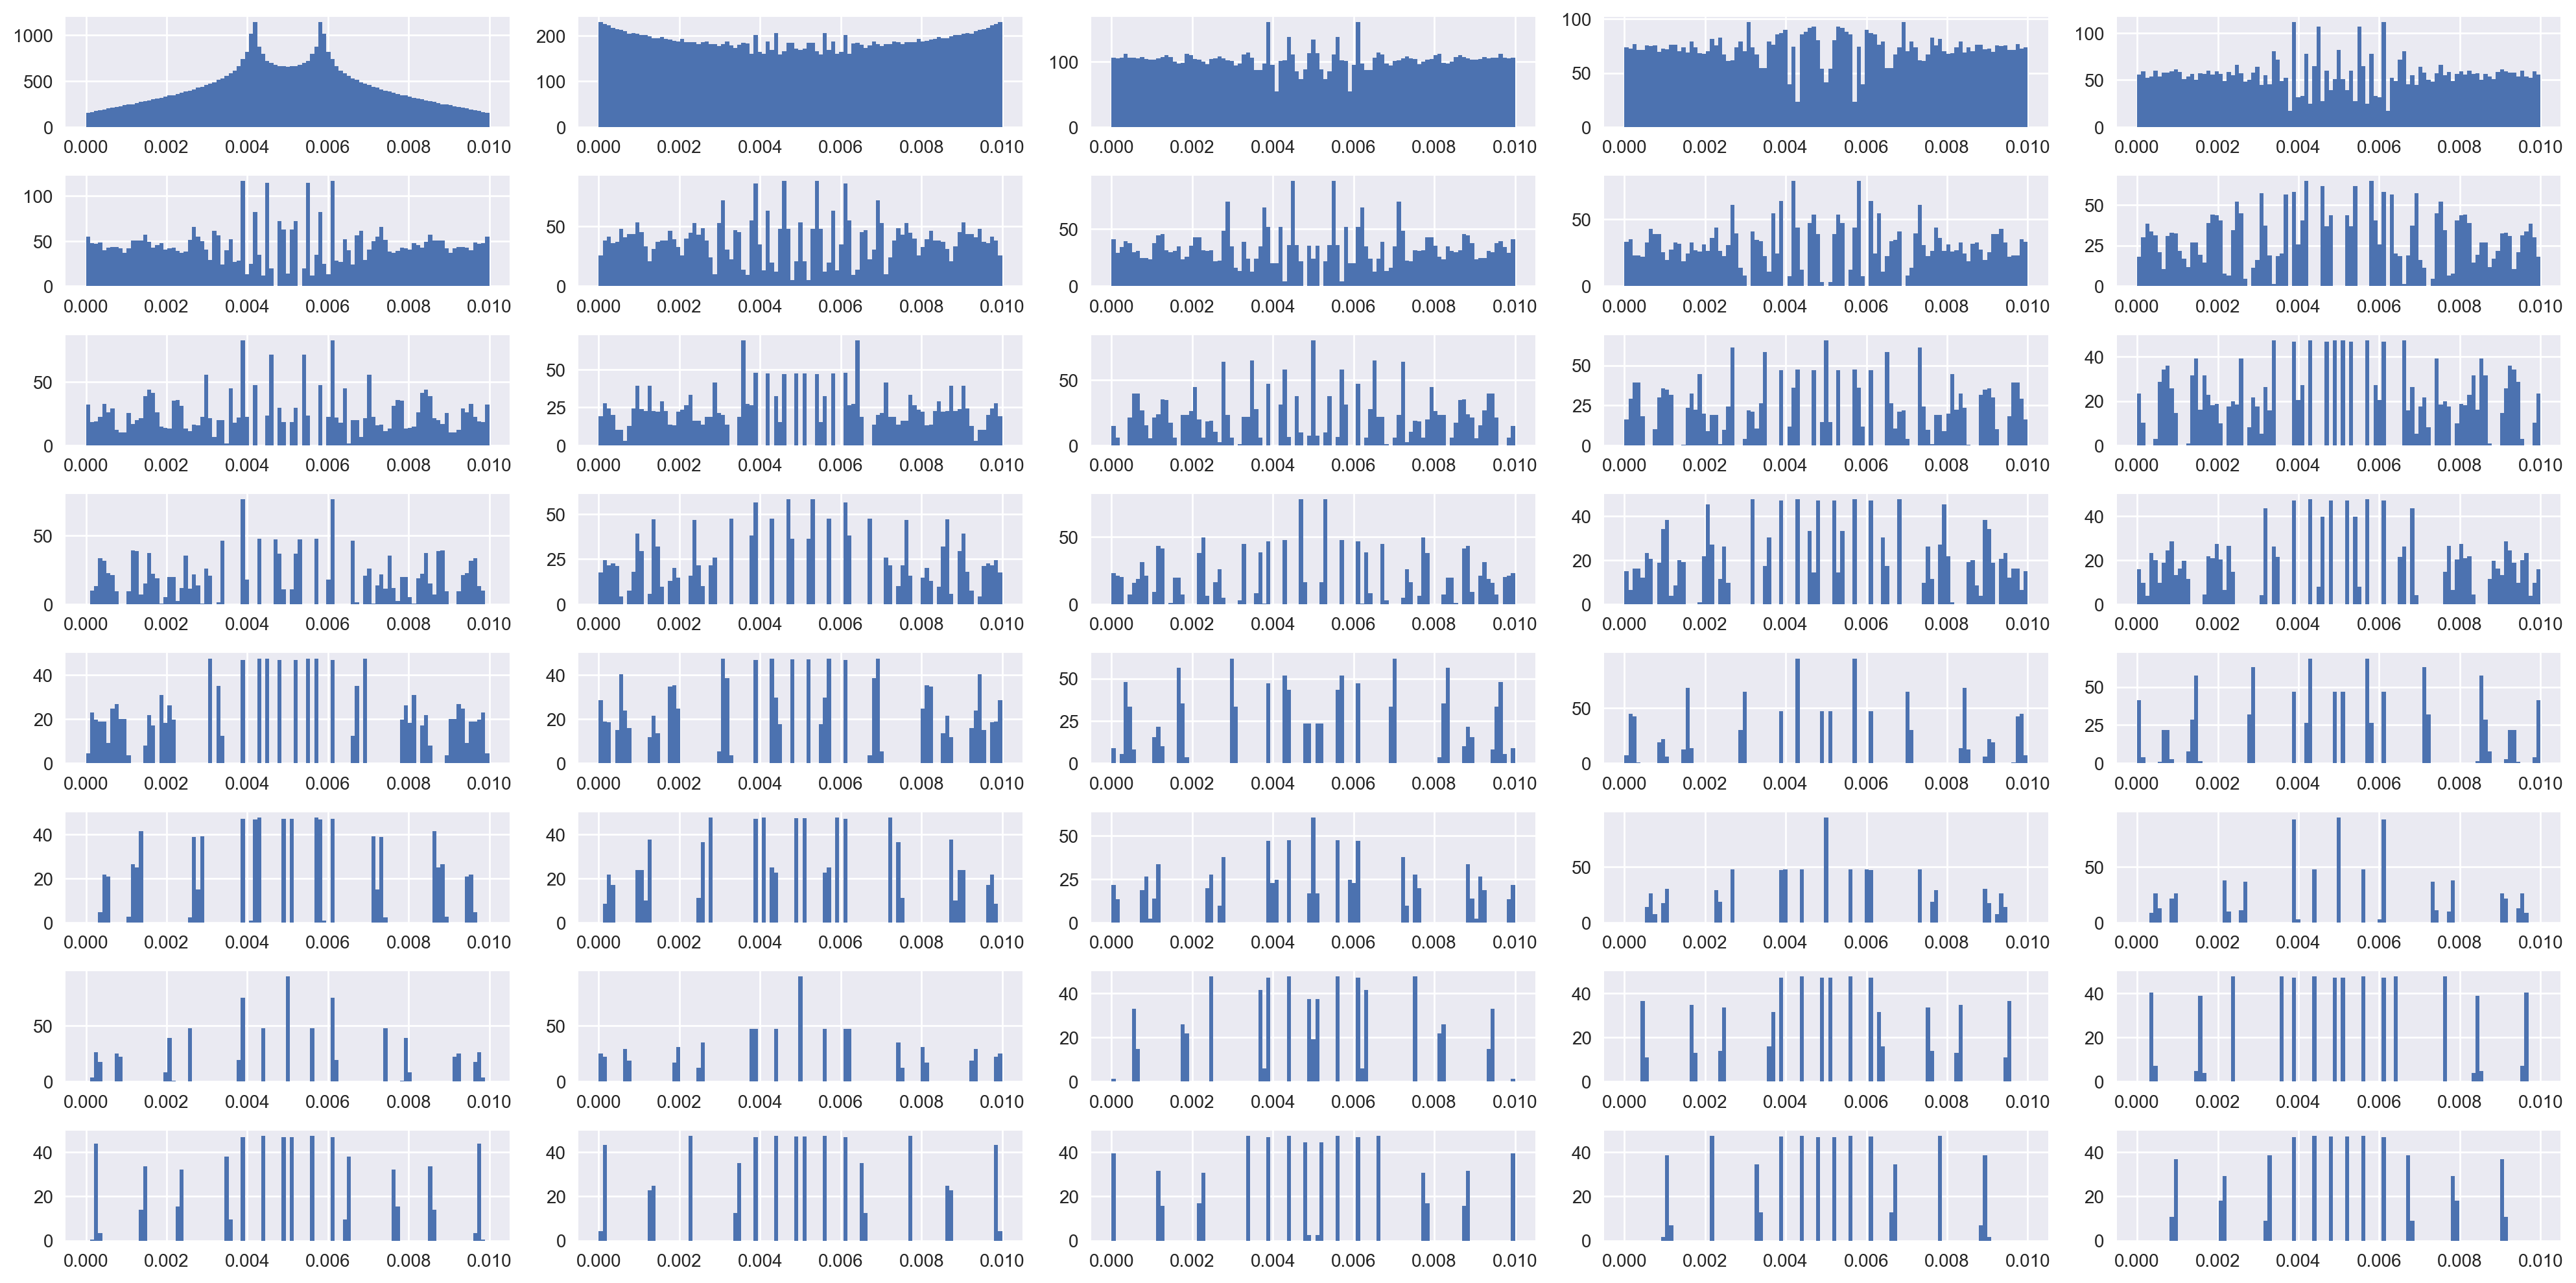

In [1202]:
# Given H, x_edges, y_edges from np.histogram2d

# Calculate how many y-bins to include in each subplot
y_step = len(H) // 40

# Initialize the plot
fig, axes = plt.subplots(8, 5, figsize=(20, 10))
axes = axes.flatten()

# Loop over each subplot to plot the data for different y-values
for i, ax in enumerate(axes):
    start_index = i * y_step
    end_index = start_index + y_step
    
    # Average over multiple y-bins to get a more stable histogram for each subplot
    avg_histogram_values = np.mean(H[start_index:end_index, :], axis=0)
    
    # Plot the histogram
    ax.bar(x_edges[:-1], avg_histogram_values, width=np.diff(x_edges), align="edge", label=f'Y = {y_edges[start_index]} to {y_edges[end_index]}')
    # ax.axvline(1, color='black', linewidth=1)
    ax.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Parameters
y_values = np.linspace(0, min_y, 40).astype(int)

# Initialize the plot
fig, axes = plt.subplots(8, 5, figsize=(20, 10))
axes = axes.flatten()

# Loop over each subplot to plot the data for different y-values
for i, y in enumerate(y_values):
    ax = axes[i]
    
    # Find the closest y-position in the data
    closest_y_index = np.argmin(np.abs(particle_positions_history[:, :, 1] - y), axis=0)
    
    # Extract the corresponding x-positions
    x_positions_at_y = np.array([particle_positions_history[closest_y_index[j], j, 0] for j in range(num_particles)])
    
    # Plot the histogram
    ax.hist(particle_positions_history[-1][:, 0], bins=100, density=False, range=(0-1, x_range+1), label=f'Y = {y}')
    ax.axvline(1, color='black', linewidth=1)
    # ax.set_xlabel('x')
    # ax.set_ylabel('Density')
    # hide legend
    ax.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
y = min_y  # The y-position of the screen
# Extract the particle positions at y = -3 or the closest to it
closest_y_index = np.argmin(np.abs(particle_positions_history[:, :, 1] - y), axis=0)

# Extract the corresponding x-positions
x_positions_at_y_minus_3 = np.array([particle_positions_history[closest_y_index[i], i, 0] for i in range(num_particles)])

# Plot the distribution of particle positions at y = -3
plt.figure(figsize=(10, 5))
# histogram bins equally spaced between 0 and x_range but with a line distribution instead of bar
plt.hist(x_positions_at_y_minus_3, bins=100, density=False, alpha=0.7, range=(0, x_range), label='Final Distribution of Particles')
# create vertical black line at x = 1
plt.axvline(1, color='black', linewidth=1)
plt.xlabel('x')
plt.ylabel('density')
# plt.title(f'Distribution of Particle Positions at Y = {y}')
plt.grid(True)
plt.show()
